# Laboratorio 5 - Text Mining

Repositorio: https://github.com/DiegoLinares11/Clasificacion-de-Tweets-usando-Mineria-de-Texto

Integrantes:
- Diego Linares 221256
- José Prince 22087

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

#  por si no lo tenees pip install wordcloud pillow
from wordcloud import WordCloud

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# RUTAS 
TRAIN_PATH = "data/train.csv"
TEST_PATH  = "data/test.csv"

## Carga de los datos

In [2]:
# 1) CARGA
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# 1.1) Dimensiones y columnas
print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("\nTrain columns:", train.columns.tolist())

# 1.2) Vistazo rápido
display(train.head(10))
display(test.head(10))

# 1.3) Datos faltantes por columna
display(train.isna().mean().sort_values(ascending=False).to_frame("missing_ratio").style.format("{:.2%}"))


Train shape: (7613, 5)
Test shape : (3263, 4)

Train columns: ['id', 'keyword', 'location', 'text', 'target']


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


,missing_ratio
location,33.27%
keyword,0.80%
id,0.00%
text,0.00%
target,0.00%


El dataset trae id, keyword, location, text, target (target = 1 desastre, 0 no) .

## Analisis exploratorio

Primeramente, se analizará como esta la distribución de las clases (1 o 0) para ver si existe un desbalance en las clases.

<Axes: title={'center': 'Distribución de clases'}, xlabel='target'>

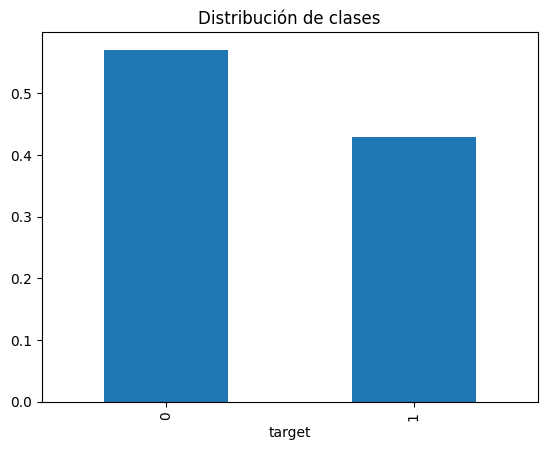

In [3]:
train["target"].value_counts(normalize=True).plot(kind="bar", title="Distribución de clases")

Se puede apreciar que si existe una diferencia en la cantidad de datos por clase pero se puede ver que esta diferencia no es significativa, por lo tanto se puede considerar que el dataset esta balanceado y se puede trabajar con este de forma adecuada. 

Ahora se va a revisat la longitud de los tweets para reconocer si existen posibles patrones en la longitud.

<Axes: xlabel='text_len', ylabel='Count'>

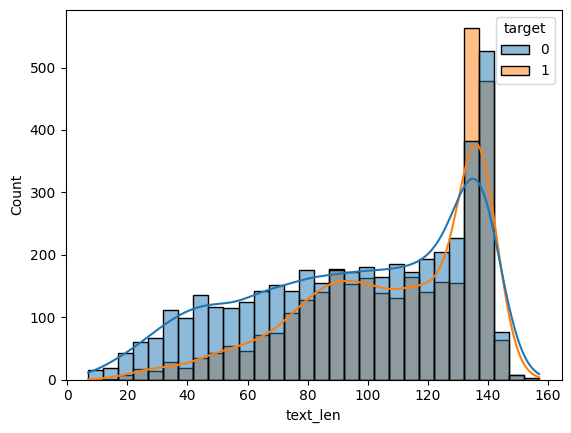

In [4]:
train["text_len"] = train["text"].str.len()
train["text_wordcount"] = train["text"].str.split().map(len)

sns.histplot(train, x="text_len", hue="target", bins=30, kde=True)

El gráfico muestra una diferencia en la distribución de la longitud de los tweets, los que no hace referencia a desastres presentan un pico muy pronunciado y concentrado alrederdor de los 140 caracteres; lo que sugiere que la mayoría de estos tweets son más largos y cercanos al límite tradicional de la plataforma. En contraste, los tweets que sí se refieren a desastres tienen una distribución más amplia y plana, lo que indica una mayor diversidad en su longitud y que son igualmente probables de ser tanto cortos como largos, lo que podría ser un patrón útil para la clasificación.

Más adelante se va a analizar la distribución de palabras (en nubes de palabras y ngramas) que se encuentran en el dataset y como se relacionan a un desastre o no.

## Limpieza

Del enunciado: minúsculas, quitar #, @, URL, emojis, puntuación; quitar stopwords; y decidir si quitar números (ojo con “911”) .

In [5]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
STOP_EN = set(stopwords.words("english"))

# patrones regex 
EMOJI_PATTERN   = re.compile("["           # rango de emojis comunes             
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
"]+", flags=re.UNICODE)
URL_PATTERN     = re.compile(r"http\S+|www\.\S+")
MENTION_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#(\w+)")   # conserva la palabra, quita '#'
HTML_TAGS       = re.compile(r"<.*?>")

# tokens super comunes de Twitter; sklearn quitará más stopwords con stop_words="english"
TW_STOPS = {"rt", "amp"}

def clean_tweet(text: str, remove_numbers=False, preserve_911=True) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = URL_PATTERN.sub(" ", t)
    t = HTML_TAGS.sub(" ", t)
    t = MENTION_PATTERN.sub(" ", t)
    t = HASHTAG_PATTERN.sub(r"\1", t)     
    t = re.sub(r"[^a-z0-9\s]", " ", t)    
    t = EMOJI_PATTERN.sub(" ", t)

    if remove_numbers:
        if preserve_911:
            t = re.sub(r"\b(?!911\b)\d+\b", " ", t) # quita números excepto 911
        else:
            t = re.sub(r"\b\d+\b", " ", t)

    t = re.sub(r"\s+", " ", t).strip()

    tokens = t.split()

    # quitar stopwords de twitter y NLTK
    tokens = [w for w in tokens if w not in TW_STOPS and w not in STOP_EN and len(w) > 1]

    return " ".join(tokens)

# aplicar
train["clean_text"] = train["text"].apply(lambda s: clean_tweet(s, remove_numbers=False))
test["clean_text"]  = test["text"].apply(lambda s: clean_tweet(s, remove_numbers=False))

display(train[["text","clean_text","target"]].head(10))


[nltk_data] Downloading package stopwords to /home/akice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text,target
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us,1
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,1
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive wildfires evacuation ord...,1
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...,1
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy 20 closed dire...,1
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...,1
7,I'm on top of the hill and I can see a fire in...,top hill see fire woods,1
8,There's an emergency evacuation happening now ...,emergency evacuation happening building across...,1
9,I'm afraid that the tornado is coming to our a...,afraid tornado coming area,1


Se quitaron caracteres especiales, tambien palamras como I'm porque se convierte en im y esta está en la lista de stopwords de NLTK que considera que es lo mismo que I am asi que la elimina, como son palabras poco informativas para un desastre solo nos generan ruido por eso se eliminan.

3) EDA: distribución de clases, longitudes y nubes de palabras

,count
target,
0,4342
1,3271


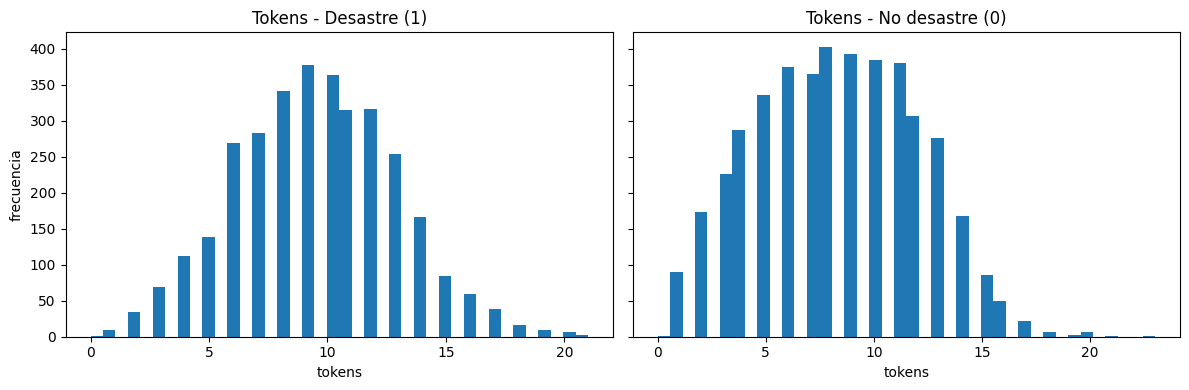

In [6]:
# 3) DISTRIBUCIÓN DE CLASES
display(train["target"].value_counts().to_frame("count"))

# 3.1) Longitud en tokens del texto limpio
train["tok_len"] = train["clean_text"].str.split().apply(len)

fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
train.loc[train["target"]==1, "tok_len"].plot(kind="hist", bins=40, ax=ax[0], title="Tokens - Desastre (1)")
train.loc[train["target"]==0, "tok_len"].plot(kind="hist", bins=40, ax=ax[1], title="Tokens - No desastre (0)")
for a in ax: a.set_xlabel("tokens"); a.set_ylabel("frecuencia")
plt.tight_layout()
plt.show()


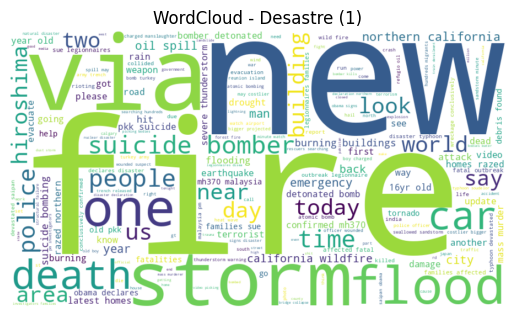

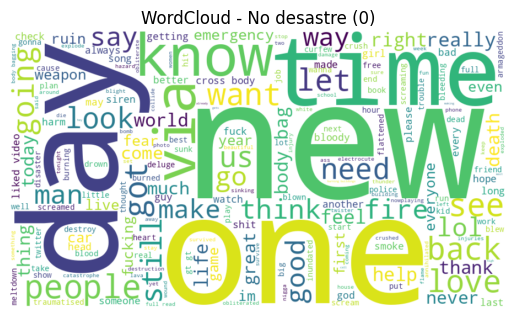

In [7]:
# 3.2) Nube de palabras por clase 
pos_text = " ".join(train.loc[train["target"]==1, "clean_text"])
neg_text = " ".join(train.loc[train["target"]==0, "clean_text"])

wc_pos = WordCloud(width=900, height=500, background_color="white").generate(pos_text)
plt.imshow(wc_pos, interpolation="bilinear"); plt.axis("off"); plt.title("WordCloud - Desastre (1)"); plt.show()

wc_neg = WordCloud(width=900, height=500, background_color="white").generate(neg_text)
plt.imshow(wc_neg, interpolation="bilinear"); plt.axis("off"); plt.title("WordCloud - No desastre (0)"); plt.show()


En tweets de desastre (1) resaltan términos como fire, flood, storm, earthquake, death, suicide, emergency, bomb.
→ Son palabras clave muy ligadas a incidentes reales.

En tweets de no desastre (0) sobresalen like, love, day, time, lol, video.
→ Reflejan conversaciones cotidianas o expresiones personales, sin relación con emergencias.

## Frecuencias de palabras y n‑gramas (unigramas/bigramas/trigramas)

El lab pide contar frecuencias por categoría y discutir si vale explorar bigramas/trigramas .

In [8]:
# 4) TOP UNIGRAMAS POR CLASE
def top_terms(df, target_value, n=25):
    vec = CountVectorizer(ngram_range=(1,1), min_df=2, stop_words="english")
    X = vec.fit_transform(df.loc[df["target"]==target_value, "clean_text"])
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"term": terms[order], "freq": freqs[order]})

top_uni_1 = top_terms(train, 1, n=30)
top_uni_0 = top_terms(train, 0, n=30)

display(top_uni_1.head(20))
display(top_uni_0.head(20))


,term,freq
0,news,137
1,disaster,121
2,california,115
3,suicide,112
4,police,109
5,people,105
6,killed,95
7,like,94
8,hiroshima,92
9,storm,89


,term,freq
0,like,254
1,new,171
2,body,116
3,video,96
4,people,94
5,love,91
6,day,86
7,know,86
8,time,84
9,got,84


Desastre (1): news, disaster, california, suicide, police, killed, storm, fires.
→ Altamente informativas para detectar eventos.

No desastre (0): like, new, body, video, love, lol, man.
→ Muchas de estas son palabras comunes en redes sociales que no aportan al contexto de desastre.

Conclusión: Los unigrams ya separan bien ambas clases.

### TOP BIGRAMAS POR CLASE

In [9]:
def top_bigrams(df, target_value, n=25):
    vec = CountVectorizer(ngram_range=(2,2), min_df=3, stop_words="english")
    X = vec.fit_transform(df.loc[df["target"]==target_value, "clean_text"])
    if X.shape[1] == 0:
        return pd.DataFrame(columns=["bigram","freq"])
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"bigram": terms[order], "freq": freqs[order]})

top_bi_1 = top_bigrams(train, 1, n=30)
top_bi_0 = top_bigrams(train, 0, n=30)

display(top_bi_1.head(20))
display(top_bi_0.head(20))

,bigram,freq
0,suicide bomber,59
1,northern california,41
2,oil spill,38
3,burning buildings,37
4,suicide bombing,35
5,california wildfire,34
6,bomber detonated,30
7,70 years,30
8,homes razed,29
9,confirmed mh370,29


,bigram,freq
0,cross body,39
1,liked video,34
2,gt gt,30
3,body bag,27
4,body bagging,24
5,burning buildings,23
6,body bags,22
7,reddit quarantine,21
8,quarantine offensive,21
9,looks like,21


Desastre (1): suicide bomber, northern california, oil spill, burning buildings, california wildfire.
→ Dan contexto adicional: no es lo mismo “suicide” que “suicide bomber”.

No desastre (0): cross body, liked video, body bagging, reddit quarantine.
→ Muchos parecen spam, moda o expresiones de comunidades online.

Conclusión: Los bigramas capturan combinaciones más claras de eventos, reducen ambigüedad.

### Para trigramas: 

In [10]:
def top_trigrams(df, target_value, n=25, min_df=4, stop_words="english"):
    vec = CountVectorizer(ngram_range=(3,3), min_df=min_df, stop_words=stop_words)
    X = vec.fit_transform(df.loc[df["target"] == target_value, "clean_text"])
    vocab = vec.get_feature_names_out()
    if X.shape[1] == 0:
        return pd.DataFrame(columns=["trigram", "freq"]), 0  # DF vacío y tamaño de vocabulario

    freqs = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(freqs)[::-1][:n]
    out = pd.DataFrame({"trigram": vocab[order], "freq": freqs[order]})
    return out, len(vocab)

# Uso
top_tri_1, V1 = top_trigrams(train, 1, n=30, min_df=4)
top_tri_0, V0 = top_trigrams(train, 0, n=30, min_df=4)

print(f"Vocab trigramas clase=1: {V1}, clase=0: {V0}")
display(top_tri_1.head(20))
display(top_tri_0.head(20))

Vocab trigramas clase=1: 546, clase=0: 328


,trigram,freq
0,suicide bomber detonated,30
1,northern california wildfire,29
2,bomber detonated bomb,28
3,homes razed northern,28
4,latest homes razed,28
5,pkk suicide bomber,28
6,razed northern california,27
7,16yr old pkk,27
8,old pkk suicide,27
9,families affected fatal,26


,trigram,freq
0,reddit quarantine offensive,21
1,quarantine offensive content,20
2,cross body bag,19
3,pick fan army,17
4,china stock market,16
5,stock market crash,16
6,reddit new content,16
7,new content policy,16
8,content policy goes,15
9,subreddits banned quarantined,15


Desastre (1): suicide bomber detonated, northern california wildfire, families affected fatal, typhoon devastated saipan.
→ Muy descriptivos, pero mucho menos frecuentes; por eso sus conteos son bajos (25–30).

No desastre (0): reddit quarantine offensive, stock market crash, cross body bag.
→ Mezclan eventos de otras temáticas (mercado, internet).

Conclusión: Los trigramas aportan mucha especificidad, pero son escasos en tweets tan cortos.

Unigrams: útiles para identificar palabras discriminantes. Son la base del modelo.

Bigrams: capturan expresiones clave (ej. “suicide bomber”), por lo que sí vale la pena incluirlos.

Trigrams: aunque interesantes, tienen baja frecuencia (pocos tweets largos los generan). Son más útiles en análisis cualitativo que como features principales en un modelo de tweets.

## Modelo

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Training
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),    # unigramas + bigramas
    min_df=3,             # descarta términos muy raros
    max_df=0.9,           # descarta términos demasiado comunes
    stop_words="english"  # refuerzo extra de limpieza
)

X_train = vectorizer.fit_transform(train["clean_text"])
X_test  = vectorizer.transform(test["clean_text"])
y_train = train["target"]


model = LogisticRegression(max_iter=1000, class_weight="balanced")

scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
print("F1 (CV):", scores.mean())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation 

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model.fit(X_tr, y_tr)
y_val_pred = model.predict(X_val)

print(classification_report(y_val, y_val_pred))

F1 (CV): 0.6087171964348689
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       874
           1       0.76      0.74      0.75       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



Para nuestro modelo se hizo un modelo de clasificón que usara regresión logística para clasificar tweets en dos categorías: relacionadas con desastres (1) y no relacionados con desastres (0). De igual forma se convirtieron los textos ne vectores, de esta forma: se incluian unigramas y bigramas en el modelo para no solo identificar palabras individuales, sino también frases cortas; se eliminan palabras raras o muy comunes para reducir el ruido entre las palabras; y se quitan los "stop words". 

La validación cruzada del conjunto de entrenamiento muestra ser de 0.6087, indicando que no hay sobre ajuste y que el modelo es consistentemente preciso. Podemos ver que el modelo presenta un accuracy del 79%, esto nos indica que el modelo no se encuentra sobreajustado y tiene un margen para hacer correctamente la predicción si un tweet es referente a un desastre o no.

In [13]:
def clasificar_tweet(texto_nuevo, vectorizer, model):
    texto_vectorizado = vectorizer.transform([texto_nuevo])
    
    prediccion = model.predict(texto_vectorizado)
    
    if prediccion[0] == 1:
        return "El tweet se relaciona con un desastre."
    else:
        return "El tweet no se relaciona con un desastre."

tweet1 = "A 7.5 magnitude earthquake strikes the coast and causes damage in several cities. #earthquake"
print(f"'{tweet1}' -> {clasificar_tweet(tweet1, vectorizer, model)}")

tweet2 = "Today is a sunny day, perfect for going to the beach and relaxing a little."
print(f"'{tweet2}' -> {clasificar_tweet(tweet2, vectorizer, model)}")

tweet3 = "A forest fire is spreading rapidly, and people are being asked to evacuate the area."
print(f"'{tweet3}' -> {clasificar_tweet(tweet3, vectorizer, model)}")

tweet4 = "¡I love my morning coffee!"
print(f"'{tweet4}' -> {clasificar_tweet(tweet4, vectorizer, model)}")

'A 7.5 magnitude earthquake strikes the coast and causes damage in several cities. #earthquake' -> El tweet se relaciona con un desastre.
'Today is a sunny day, perfect for going to the beach and relaxing a little.' -> El tweet no se relaciona con un desastre.
'A forest fire is spreading rapidly, and people are being asked to evacuate the area.' -> El tweet se relaciona con un desastre.
'¡I love my morning coffee!' -> El tweet no se relaciona con un desastre.


In [14]:
custom_tweet = input("Ingresa un tweet: ")

print(f"'{custom_tweet}' -> {clasificar_tweet(custom_tweet, vectorizer, model)}")

Ingresa un tweet:  Yesteday, another tsunami hit the coast


'Yesteday, another tsunami hit the coast' -> El tweet se relaciona con un desastre.
